<p style="font-size:36px;text-align:center"> <b>Seattle Rain Predictions</b> </p>

<h1>1. Description

Besides coffee, grunge and technology companies, one of the things that Seattle is most famous for is how often it rains. This dataset contains complete records of daily rainfall patterns from January 1st, 1948 to December 12, 2017.

<p>The dataset contains five columns: </p>

* DATE = the date of the observation
* PRCP = the amount of precipitation, in inches
* TMAX = the maximum temperature for that day, in degrees Fahrenheit
* TMIN = the minimum temperature for that day, in degrees Fahrenheit
* RAIN = TRUE if rain was observed on that day, FALSE if it was not

<h1>2. Source </h1>

<p>https://www.kaggle.com/rtatman/did-it-rain-in-seattle-19482017 </p>
<p>This data was collected at the Seattle-Tacoma International Airport.</p>

<h1>3. Problem Statement

Based on given data set predict whether if there was rain observed on a day or not.

<h1> 4. EDA and Data Pre-Processing </h1>

In [1]:
#Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split


%matplotlib inline

C:\Users\patil\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\patil\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df=pd.read_csv('seattleWeather_1948-2017.csv')
df.shape

(25551, 5)

The dataset  contains 25551 data points with 4 features and 1 class label.

In [3]:
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [4]:
df.describe()

,PRCP,TMAX,TMIN
count,25548.000000,25551.000000,25551.000000
mean,0.106222,59.544206,44.514226
std,0.239031,12.772984,8.892836
min,0.000000,4.000000,0.000000
25%,0.000000,50.000000,38.000000
50%,0.000000,58.000000,45.000000
75%,0.100000,69.000000,52.000000
max,5.020000,103.000000,71.000000


As we can see from the above table , the max row has values that are far away from mean points.So this points must be outlier.
Here we can see the outlier present in the data set by plotting the box plot for the same.

Text(0.5,1,'Box plot with Outliers')

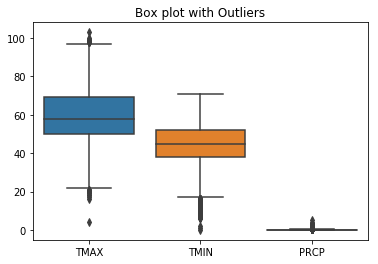

In [5]:
sns.boxplot(data=df[['TMAX','TMIN','PRCP']])
plt.title("Box plot with Outliers")

<p>The points which are present above and below the whiskers of the box plot are the outliers. We would use the Inter-Quartile Range(IQR) to remove this outliers.</p>

<p> The max point of the whisker is given by Q3+1.5*(IQR) and the min point is given by Q1-1.5*(IQR).</p>

<p>  where IQR=Q3-Q1  </p>
<p>  and Q1,Q3 are first and third quartiles respectively.

In [6]:
tmin_Q=df['TMIN'].quantile([0.25,0.75])
tmax_Q=df['TMAX'].quantile([0.25,0.75])
prcp_Q=df['PRCP'].quantile([0.25,0.75])

In [7]:
Q3_tmin=tmin_Q.get_values()[1]
Q1_tmin=tmin_Q.get_values()[0]

Q3_tmax=tmax_Q.get_values()[1]
Q1_tmax=tmax_Q.get_values()[0]

Q3_prcp=prcp_Q.get_values()[1]
Q1_prcp=prcp_Q.get_values()[0]

In [8]:
iqr_tmin=Q3_tmin-Q1_tmin
iqr_tmax=Q3_tmax-Q1_tmax
iqr_prcp=Q3_prcp-Q1_prcp

In [9]:
df=df.drop(df[df['TMIN']< Q1_tmin-1.5*iqr_tmin].index)
df=df.drop(df[(df['TMAX']< Q1_tmax-1.5*iqr_tmax) | (df['TMAX']> Q3_tmax+1.5*iqr_tmax)].index)
df=df.drop(df[(df['PRCP']< 0) | (df['PRCP']> Q3_prcp+1.5*iqr_prcp)].index)

df.shape

(21893, 5)

After removal of outliers from dataset we have  21893  points and the box plot after removal of outlier is shown below.

Text(0.5,1,'Box Plot after removal of outliers')

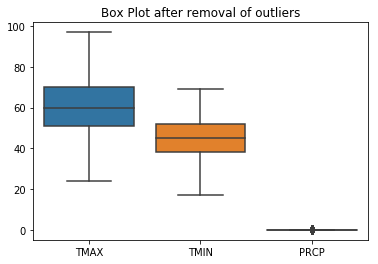

In [10]:
sns.boxplot(data=df[['TMAX','TMIN','PRCP']])
plt.title("Box Plot after removal of outliers")

In [11]:
#Some user-defined functions

def Rates(tn,fp,fn,tp):
    TPR=float(tp/(tp+fn))
    TNR=float(tn/(tn+fp))
    FPR=float(fp/(tn+fp))
    FNR=float(fn/(tp+fn))
    print("True Positive Rate or Sensitivity = %f" %(TPR*100))
    print("True Negative Rate or Specificity = %f" %(TNR*100))
    print("False Positive Rate or Fall-out = %f" %(FPR*100))
    print("False Negative Rate or Missclassification rate = %f" %(FNR*100))


def tran(Y):
    if Y==True:
        temp=1
    else:
        temp=0
    return temp        
       
Y=df['RAIN'].map(tran)    

In [12]:
df=df.drop(['DATE','RAIN'],axis=1)
df.head()

,PRCP,TMAX,TMIN
4,0.17,45,32
7,0.04,48,35
8,0.12,50,31
10,0.01,42,32
11,0.00,41,26


Now we will check whether there is NA present in the data or not.IF NA is present we would impute that NA with value equal to mean of the column.

In [13]:
x=df['TMAX'].isna()
x.value_counts()

False    21893
Name: TMAX, dtype: int64

In [14]:
x=df['TMIN'].isna()
x.value_counts()

False    21893
Name: TMIN, dtype: int64

In [15]:
x=df['PRCP'].isna()
x.value_counts()

False    21890
True         3
Name: PRCP, dtype: int64

As we can see that there 3 values in 'PRCP' with NA. We would impute it mean of the value in the column using Imputer function.

In [16]:
im=Imputer()
X=im.fit_transform(df)

Now once we have the entire data-set its time we standardised the data using StandardScaler.

In [17]:
sd=StandardScaler()
sd_data=sd.fit_transform(X)

In [18]:
Y.value_counts()

0    14569
1     7324
Name: RAIN, dtype: int64

Dividing the entire datasets into train and test data.We would use 70% of the entire data for training the model and 30% of the entire data for testing the model.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(sd_data, Y, test_size=0.3, random_state=42)

<h1> 4. Machine Learning Model 

We would be using Logistic Regression as our model for training the data.

Logistic Regression as hyper-parameter 'C' whoes optimal value is find using cross-validation. We would be using Grid Search CV with cv=5.

In [20]:
tuned_parameters = [{'C': [10**-4, 10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4]}]

In [21]:
#Using GridSearchCV
model = GridSearchCV(LogisticRegression(), tuned_parameters,
                     scoring = 'accuracy', cv=5,n_jobs=-1)
model.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid=[{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

The optimal value of C is found using elbow-method

In [22]:
cv_scores=[x[1] for x in model.grid_scores_]

#Calculating misclassification error
MSE = [1 - x for x in cv_scores]

#Finding best K
val=list(tuned_parameters[0].values())
optimal_value=val[0][MSE.index(min(MSE))]

print("\n The optimal value of C im Logistic Regression is %f ." %optimal_value)



 The optimal value of C im Logistic Regression is 10.000000 .


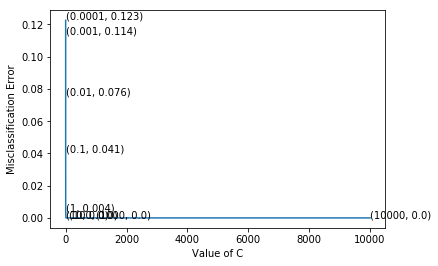

In [23]:
# plot misclassification error vs C 
plt.plot(val[0], MSE)

for xy in zip(val[0], np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Value of C')
plt.ylabel('Misclassification Error')
plt.show()

In [24]:
lr=LogisticRegression(C=optimal_value)
lr.fit(X_train,y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [25]:
y_pred=lr.predict(X_test)

In [26]:
lr.score(X_test,y_test)

0.9996954933008526

<p> The accuracy of the model comes out to be <b> 99.96 % </b>. </p>
<p> Lets plot the confusion matrix for the same to see FNR and FPR

In [27]:
tn, fp, fn, tp =confusion_matrix(y_test, y_pred).ravel()
Rates(tn,fp,fn,tp)

True Positive Rate or Sensitivity = 100.000000
True Negative Rate or Specificity = 99.954679
False Positive Rate or Fall-out = 0.045321
False Negative Rate or Missclassification rate = 0.000000


Text(29,0.5,'True Value')

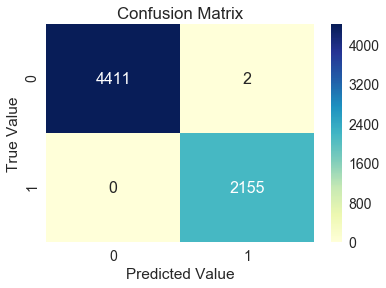

In [28]:
x=confusion_matrix(y_test, y_pred)
cm_df=pd.DataFrame(x,index=[0,1],columns=[0,1])

sns.set(font_scale=1.4,color_codes=True,palette="deep")
sns.heatmap(cm_df,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

<h1> 5. Conclusion </h1>

We were able to correctly predict the Rain in Seattle using Logistic Regression Model with an Accuracy of <b>99.96 % </b> 